# Red convolucional para Fashion-MNIST 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mxnet import autograd, gluon, npx
import mxnet as mx
from my_wrapper import wrapper as myw
from mxnet.gluon.data.vision import datasets, transforms

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

npx.set_np()

**Librería propia: ```my_wrapper```**

Importamos una librería propia que envuelve la implementación de modelos en gluon para que estos sean compatibles con la librería sklearn

## Obtener los datos

### Cargar desde .csv

In [3]:
df_train = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('fashion-mnist_test.csv')

# permutamos filas y cogemos solo una fracción de los datos
df_train = df_train.sample(frac=0.1, random_state=7)
df_test = df_test.sample(frac=0.1, random_state=7)

Cogeremos únicamente 6.000 entradas de las 60.000 de train, y 1.000 entradas de las 10.000 de test.

In [4]:
X_train = df_train[df_train.columns[1:]].values
y_train = df_train[df_train.columns[0]].values.reshape(-1,)

X_test = df_test[df_test.columns[1:]].values
y_test = df_test[df_test.columns[0]].values.reshape(-1,)

## Semilla

Para que se puedan replicar los experimentos (por ejemplo la inicialización aleatoria de los pesos de la red neuronal que creemos):

In [5]:
mx.random.seed(128)

## Definición de la red y otros parámetros

### Funciones de creación

Definimos funciones que generen un modelo de red neuronal de la forma propia de la API de gluon:

In [6]:
def fashion_net():
    net = gluon.nn.Sequential()

    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2, padding=0))
    net.add(gluon.nn.Dropout(rate=0.3))
    
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, strides=1))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2, padding=0))
    net.add(gluon.nn.Dropout(rate=0.3))
    
    net.add(gluon.nn.Dense(256))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dropout(rate=0.3))
    
    net.add(gluon.nn.Dense(64))
    net.add(gluon.nn.BatchNorm())
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dropout(rate=0.3))
    
    net.add(gluon.nn.Dense(10))
    
    return net

### Función de pérdida

También definimos la función de pérdida, que se utilizará en el entrenamiento del modelo.

In [7]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Búsqueda del mejor ```alpha```

In [9]:
kfold = KFold(n_splits=5)

net = myw.GluonClassifier(model_function=fashion_net, loss_function=loss,
                         batch_size=256, epochs=100, optimizer='adam',
                         verbose=False, format_img_data=(1, 28, 28))

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])
    

l_alpha = [10.**k for k in range(-7, 0)]
grid_params = {'net__alpha': l_alpha} 


grid_search = GridSearchCV(pipe, grid_params, cv=kfold,
                           return_train_score=True,
                           verbose=3)

### Búsqueda en rejilla con validación cruzada

In [10]:
grid_search.fit(X_test, y_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END net__alpha=1e-07;, score=(train=1.000, test=0.855) total time= 4.3min
[CV 2/5] END net__alpha=1e-07;, score=(train=1.000, test=0.860) total time= 4.3min
[CV 3/5] END net__alpha=1e-07;, score=(train=1.000, test=0.860) total time= 4.2min
[CV 4/5] END net__alpha=1e-07;, score=(train=1.000, test=0.805) total time= 4.1min
[CV 5/5] END net__alpha=1e-07;, score=(train=1.000, test=0.875) total time= 4.1min
[CV 1/5] END net__alpha=1e-06;, score=(train=1.000, test=0.845) total time= 3.9min
[CV 2/5] END net__alpha=1e-06;, score=(train=1.000, test=0.860) total time= 3.5min
[CV 3/5] END net__alpha=1e-06;, score=(train=1.000, test=0.860) total time= 3.5min
[CV 4/5] END net__alpha=1e-06;, score=(train=1.000, test=0.820) total time= 3.5min
[CV 5/5] END net__alpha=1e-06;, score=(train=1.000, test=0.845) total time= 3.5min
[CV 1/5] END net__alpha=1e-05;, score=(train=1.000, test=0.845) total time= 3.5min
[CV 2/5] END net__alpha=1e-

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('net',
                                        GluonClassifier(batch_size=256,
                                                        epochs=100,
                                                        format_img_data=(1, 28,
                                                                         28),
                                                        loss_function=SoftmaxCrossEntropyLoss(batch_axis=0, w=None),
                                                        model_function=<function fashion_net at 0x7f785f60f820>,
                                                        optimizer='adam'))]),
             param_grid={'net__alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                        0.01, 0.1]},
             return_train_score=True, verbose=3)

In [11]:
grid_search.best_params_

{'net__alpha': 1e-07}

### Evolución con cambio de ```alpha```

Rango de 'alpha': 0.000000 - 0.10
Mejor 'alpha' = 0.000000
Mejor puntuación = 0.851


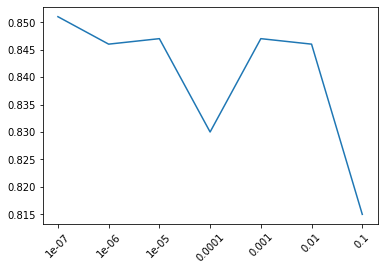

In [12]:
alpha_range = [10**k for k in range(-7, 0)]
print("Rango de 'alpha': %f - %.2f" % (np.array(alpha_range).min(), np.array(alpha_range).max()))
print("Mejor 'alpha' = %f" % (grid_search.best_params_['net__alpha']))
print("Mejor puntuación = %.3f" % (grid_search.best_score_))

plt.xticks(range(len(alpha_range)), alpha_range, rotation=45)
_ = plt.plot( grid_search.cv_results_['mean_test_score'])

## Validación con datos de test

In [23]:
net = myw.GluonClassifier(model_function=fashion_net, loss_function=loss,
                         batch_size=256, epochs=100, optimizer='adam',
                         alpha=grid_search.best_params_['net__alpha'],
                         verbose=False, format_img_data=(1, 28, 28))

pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('net', net)])

In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_sc', StandardScaler()),
                ('net',
                 GluonClassifier(alpha=1e-07, batch_size=256, epochs=100,
                                 format_img_data=(1, 28, 28),
                                 loss_function=SoftmaxCrossEntropyLoss(batch_axis=0, w=None),
                                 model_function=<function fashion_net at 0x7f785f60f820>,
                                 optimizer='adam'))])

In [25]:
yp = pipe.predict(X_test)

In [26]:
print("Accuracy: %.3f\t" % (accuracy_score(y_test, yp)))

Accuracy: 0.895	


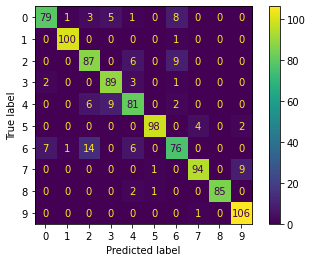

In [27]:
cm = confusion_matrix(y_test, yp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Validación cruzada

Con el mejor estimador obtenido en la búsqueda en rejilla

```cross_val_predict```

In [18]:
kfold = KFold(n_splits=5)

y_pred_cv = cross_val_predict(grid_search.best_estimator_, X_test, y_test, cv=kfold)#grid_search.best_estimator_

In [20]:
print("Accuracy: %.3f\t" % (accuracy_score(y_test, y_pred_cv)))

Accuracy: 0.842	


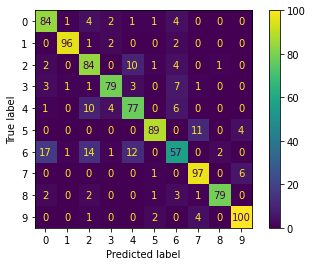

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()